In [6]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNetV2
from scipy.ndimage import gaussian_filter
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects
from skimage.segmentation import clear_border
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [7]:
# Dataset paths
data_dirs = {
    "Non-Cancer": "C:/Users/Acer/Downloads/computer_vision_project/Breast_cancer/Non_Cancer_done",
    "Early Stage": "C:/Users/Acer/Downloads/computer_vision_project/Breast_cancer/Early_phase",
    "Middle Stage": "C:/Users/Acer/Downloads/computer_vision_project/Breast_cancer/Middle_phase"
}

In [8]:
# 1. Load Dataset and Labels
def load_data_and_labels(data_dirs):
    images, labels = [], []
    for label, dir_path in enumerate(data_dirs.values()):
        for file in os.listdir(dir_path):
            img_path = os.path.join(dir_path, file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (128, 128))  # Resize for consistency
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

images, labels = load_data_and_labels(data_dirs)

In [9]:
# 2. Preprocess Images
def preprocess_images(images):
    grayscale_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
    normalized_images = [img / 255.0 for img in grayscale_images]
    return np.array(normalized_images)[..., np.newaxis]

preprocessed_images = preprocess_images(images)

In [10]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(preprocessed_images, labels, test_size=0.2, random_state=42)


In [11]:
# 3. Image Processing Techniques
def process_images_pipeline(images):
    # Apply Gaussian Smoothing
    smoothed = [gaussian_filter(img.squeeze(), sigma=1) for img in images]
    # Apply Histogram Equalization
    equalized = [cv2.equalizeHist((img * 255).astype(np.uint8)) for img in smoothed]
    return np.array(equalized)

processed_images = process_images_pipeline(X_train)

In [12]:
# 4. Image Segmentation
def segment_images(images):
    segmented_images = []
    for img in images:
        img = img * 255
        thresh_val = threshold_otsu(img)
        binary = img > thresh_val
        binary = remove_small_objects(binary, min_size=50)
        binary = clear_border(binary)
        segmented_images.append(binary.astype(float))
    return np.array(segmented_images)

segmented_images = segment_images(processed_images)


In [13]:
# 5. Feature Extraction (HOG)
def extract_hog_features(images):
    hog_features = []
    for img in images:
        features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

X_train_hog = extract_hog_features(segmented_images)
X_test_hog = extract_hog_features(segment_images(process_images_pipeline(X_test)))

In [14]:
# 2. Machine Learning Models (SVM and Random Forest)
def extract_hog_features(images):
    hog_features = []
    for img in images:
        features = hog(img.squeeze(), orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)

In [15]:
# Train SVM
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_hog, y_train)
y_pred_svm = svm_model.predict(X_test_hog)


In [16]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_hog, y_train)
y_pred_rf = rf_model.predict(X_test_hog)

In [17]:
# Evaluation for Machine Learning Models
print("SVM Classification Report")
print(classification_report(y_test, y_pred_svm))

SVM Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1609
           1       0.58      0.57      0.58      1221
           2       0.58      0.59      0.59      1251

    accuracy                           0.74      4081
   macro avg       0.72      0.72      0.72      4081
weighted avg       0.74      0.74      0.74      4081



In [18]:
print("Random Forest Classification Report")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1609
           1       0.62      0.64      0.63      1221
           2       0.63      0.64      0.64      1251

    accuracy                           0.77      4081
   macro avg       0.75      0.75      0.75      4081
weighted avg       0.77      0.77      0.77      4081



In [19]:

# 3. CNN Model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.35),
    
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
early_stopping_cnn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32,
    epochs=50,
    callbacks=[early_stopping_cnn]
)

Epoch 1/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 306s 591ms/step - accuracy: 0.6911 - loss: 10.9170 - val_accuracy: 0.6165 - val_loss: 3.6873
Epoch 2/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 324s 634ms/step - accuracy: 0.7302 - loss: 2.5650 - val_accuracy: 0.7444 - val_loss: 1.4985
Epoch 3/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 424s 715ms/step - accuracy: 0.7648 - loss: 1.2685 - val_accuracy: 0.7633 - val_loss: 1.0633
Epoch 4/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 341s 667ms/step - accuracy: 0.7679 - loss: 1.1855 - val_accuracy: 0.6667 - val_loss: 1.3734
Epoch 5/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 416s 733ms/step - accuracy: 0.7551 - loss: 1.6983 - val_accuracy: 0.7608 - val_loss: 0.7797
Epoch 6/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 350s 685ms/step - accuracy: 0.7946 - loss: 0.8240 - val_accuracy: 0.8236 - val_loss: 0.7808
Epoch 7/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 357s 698ms/step - accuracy: 0.7892 - loss: 0.9330 - val_accuracy: 0.7653 - val_loss: 0.8196
Epoch 8/50
511/511 ━━━━━━━━━━━━━━━━━━━━ 355s 695ms/step - accuracy: 0.7947 

In [21]:
# Evaluate CNN
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
print(f"CNN Test Loss: {cnn_loss}, Test Accuracy: {cnn_accuracy}")

128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.8096 - loss: 0.6178
CNN Test Loss: 0.6185510158538818, Test Accuracy: 0.8061749339103699


In [24]:
def mobilenet_data_generator(images, labels, batch_size=32):
    """
    A generator that yields preprocessed images and labels in batches.
    """
    num_samples = len(images)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_images = images[offset:offset + batch_size]
            batch_labels = labels[offset:offset + batch_size]
            processed_images = preprocess_mobilenet_images(batch_images)
            yield processed_images, batch_labels

# Training generator
train_generator = mobilenet_data_generator(X_train, y_train, batch_size=32)
test_generator = mobilenet_data_generator(X_test, y_test, batch_size=32)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

mobilenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [26]:
early_stopping_mobilenet = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model using the generator
mobilenet_history = mobilenet_model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,  # Number of batches per epoch
    validation_data=test_generator,
    validation_steps=len(X_test) // 32,  # Number of validation batches
    epochs=35,
    callbacks=[early_stopping_mobilenet]
)


Epoch 1/35
510/510 ━━━━━━━━━━━━━━━━━━━━ 224s 393ms/step - accuracy: 0.3693 - loss: 2.9107 - val_accuracy: 0.3962 - val_loss: 1.2511
Epoch 2/35
510/510 ━━━━━━━━━━━━━━━━━━━━ 175s 344ms/step - accuracy: 0.3820 - loss: 1.2232 - val_accuracy: 0.3962 - val_loss: 1.1320
Epoch 3/35
510/510 ━━━━━━━━━━━━━━━━━━━━ 194s 380ms/step - accuracy: 0.3942 - loss: 1.1308 - val_accuracy: 0.3959 - val_loss: 1.1068
Epoch 4/35
510/510 ━━━━━━━━━━━━━━━━━━━━ 167s 327ms/step - accuracy: 0.3928 - loss: 1.1113 - val_accuracy: 0.3979 - val_loss: 1.0984
Epoch 5/35
510/510 ━━━━━━━━━━━━━━━━━━━━ 167s 328ms/step - accuracy: 0.3952 - loss: 1.1007 - val_accuracy: 0.3969 - val_loss: 1.0903
Epoch 6/35
510/510 ━━━━━━━━━━━━━━━━━━━━ 144s 283ms/step - accuracy: 0.3952 - loss: 1.0948 - val_accuracy: 0.3986 - val_loss: 1.0884
Epoch 7/35
510/510 ━━━━━━━━━━━━━━━━━━━━ 138s 270ms/step - accuracy: 0.3950 - loss: 1.0914 - val_accuracy: 0.3964 - val_loss: 1.0886
Epoch 8/35
510/510 ━━━━━━━━━━━━━━━━━━━━ 134s 263ms/step - accuracy: 0.3957 -

In [27]:
# Evaluate the MobileNetV2 model before fine-tuning
mobilenet_loss_before, mobilenet_accuracy_before = mobilenet_model.evaluate(
    test_generator,
    steps=len(X_test) // 32  # Number of batches in the test set
)

print(f"MobileNetV2 (Before Fine-Tuning) Test Loss: {mobilenet_loss_before}, Test Accuracy: {mobilenet_accuracy_before}")


127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 196ms/step - accuracy: 0.3985 - loss: 1.0872
MobileNetV2 (Before Fine-Tuning) Test Loss: 1.088767409324646, Test Accuracy: 0.3934304714202881


In [29]:
# Unfreeze all layers for fine-tuning
import tensorflow as tf

for layer in base_model.layers:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
mobilenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model using the generator
fine_tune_history = mobilenet_model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,  # Number of batches per epoch
    validation_data=test_generator,
    validation_steps=len(X_test) // 32,  # Number of validation batches
    epochs=30,
    callbacks=[early_stopping_mobilenet]
)

Epoch 1/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 610s 1s/step - accuracy: 0.3965 - loss: 1.0268 - val_accuracy: 0.3934 - val_loss: 1.0936
Epoch 2/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 568s 1s/step - accuracy: 0.3965 - loss: 0.8186 - val_accuracy: 0.3961 - val_loss: 1.0945
Epoch 3/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 607s 1s/step - accuracy: 0.3970 - loss: 0.7604 - val_accuracy: 0.3984 - val_loss: 1.0953
Epoch 4/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 599s 1s/step - accuracy: 0.3957 - loss: 0.7449 - val_accuracy: 0.3979 - val_loss: 1.0963
Epoch 5/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 606s 1s/step - accuracy: 0.3976 - loss: 0.7384 - val_accuracy: 0.3971 - val_loss: 1.0972
Epoch 6/30
510/510 ━━━━━━━━━━━━━━━━━━━━ 588s 1s/step - accuracy: 0.3988 - loss: 0.7313 - val_accuracy: 0.3942 - val_loss: 1.0982


In [30]:
mobilenet_loss, mobilenet_accuracy = mobilenet_model.evaluate(
    test_generator,
    steps=len(X_test) // 32  # Number of batches in the test set
)

print(f"MobileNetV2 Test Loss: {mobilenet_loss}, Test Accuracy: {mobilenet_accuracy}")


127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 175ms/step - accuracy: 0.3884 - loss: 1.0946
MobileNetV2 Test Loss: 1.0937451124191284, Test Accuracy: 0.3929365277290344


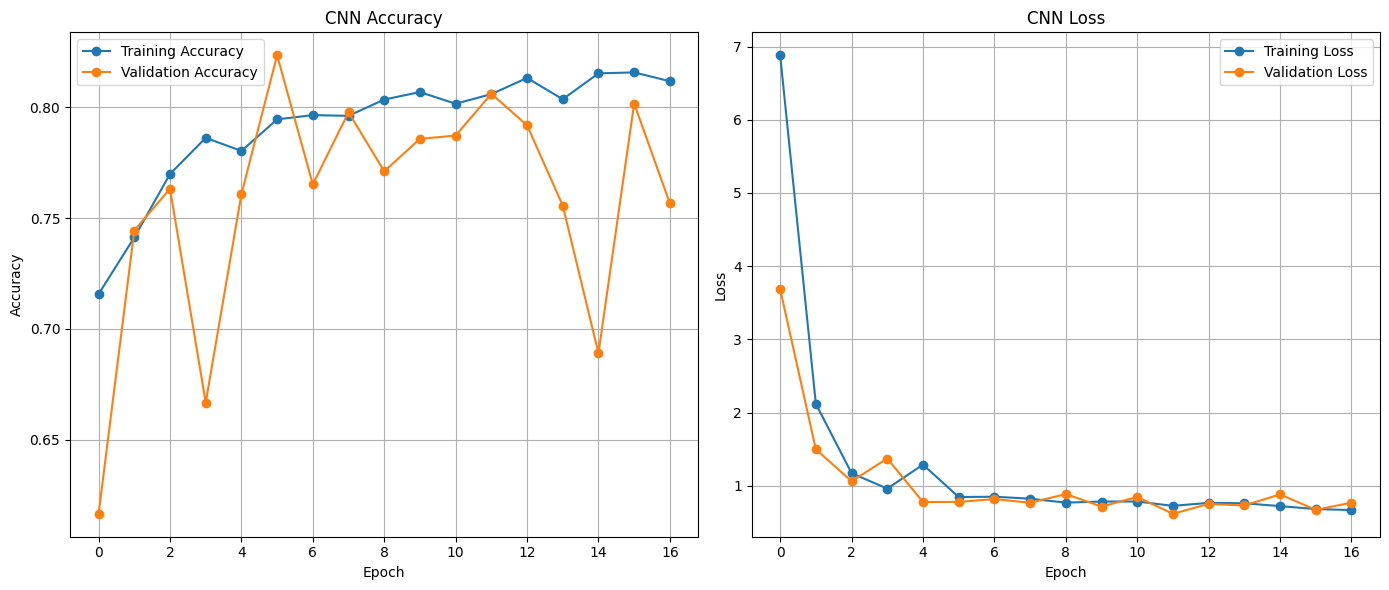

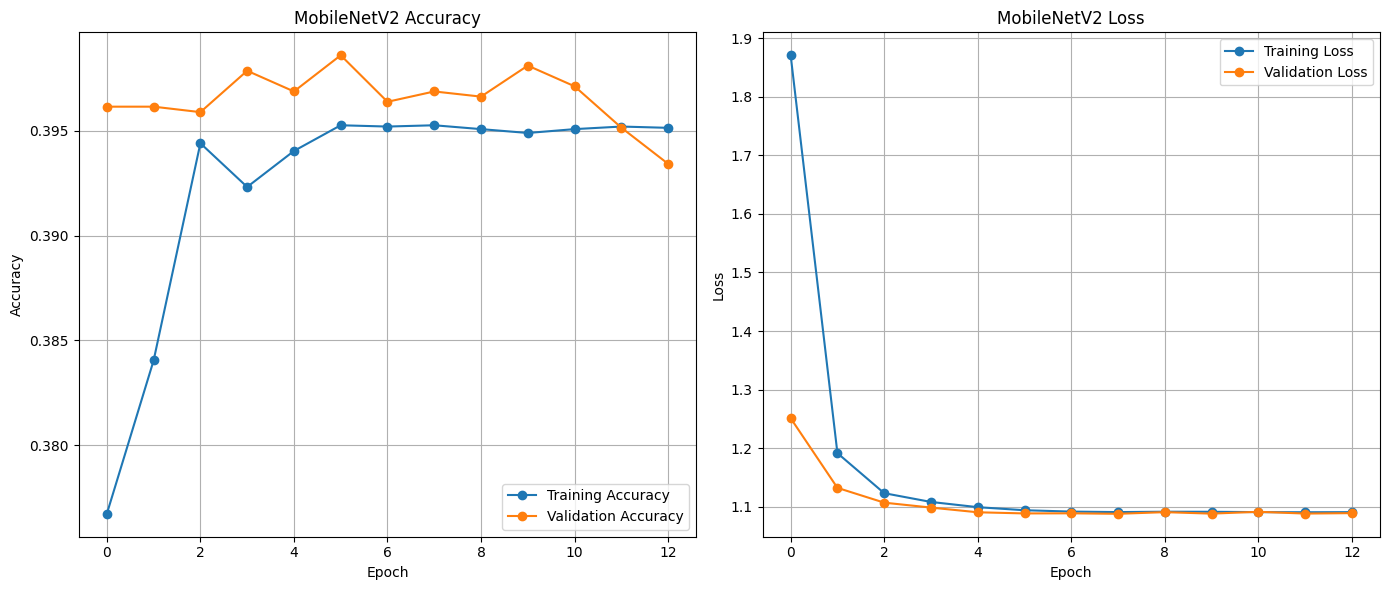

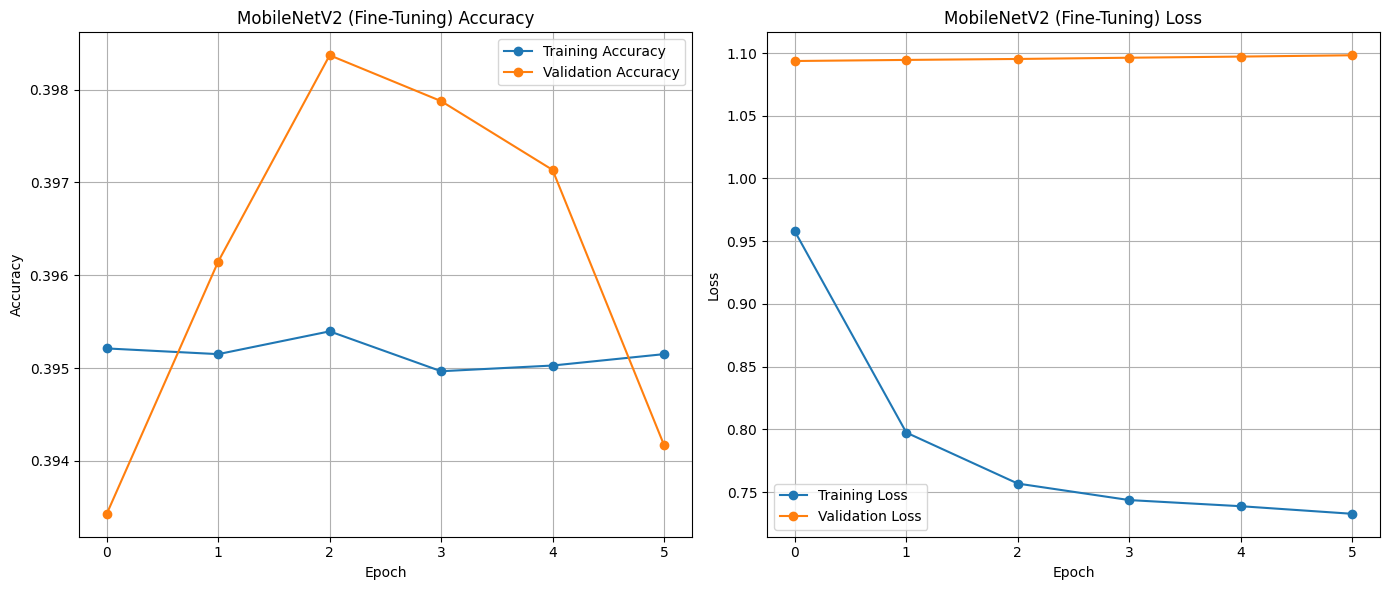

In [31]:
def plot_training_history(history, model_name):
    """
    Plots training and validation accuracy and loss for a given model history.
    """
    # Extract history data
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create subplots
    plt.figure(figsize=(14, 6))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(accuracy, label='Training Accuracy', marker='o')
    plt.plot(val_accuracy, label='Validation Accuracy', marker='o')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='o')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot for CNN
plot_training_history(cnn_history, "CNN")

# Plot for MobileNetV2
plot_training_history(mobilenet_history, "MobileNetV2")

# Plot for MobileNetV2 Fine-Tuning (if applicable)
plot_training_history(fine_tune_history, "MobileNetV2 (Fine-Tuning)")


In [32]:
# 5. Accuracy Comparison
svm_accuracy = accuracy_score(y_test, y_pred_svm)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print("Model Comparison:")
print(f"SVM Accuracy: {svm_accuracy * 100:.2f}%")
print(f"Random Forest Accuracy: {rf_accuracy * 100:.2f}%")
print(f"CNN Accuracy: {cnn_accuracy * 100:.2f}%")
print(f"MobileNetV2 Accuracy: {mobilenet_accuracy * 100:.2f}%")

Model Comparison:
SVM Accuracy: 74.22%
Random Forest Accuracy: 76.89%
CNN Accuracy: 80.62%
MobileNetV2 Accuracy: 39.29%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
Predicted Phase: Non-Cancer
Confidence Score: 38.85%
Class Probabilities:
Non-Cancer: 38.85%
Early Phase: 34.37%
Middle Phase: 26.78%


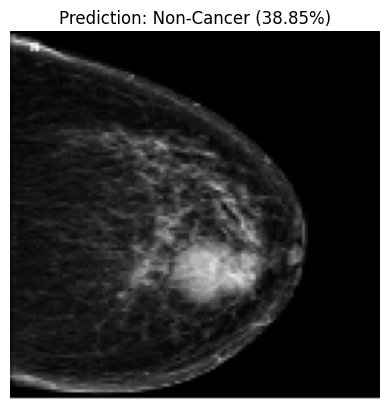

In [52]:
# Function to preprocess and predict on a single image for CNN model
def predict_image_cnn(image_path, model):
    # Load the image and resize to (128, 128)
    image = load_img(image_path, target_size=(128, 128), color_mode='rgb')
    image_array = img_to_array(image)
    
    # Convert to grayscale (since CNN is trained on grayscale images)
    gray_image = cv2.cvtColor(image_array.astype(np.uint8), cv2.COLOR_RGB2GRAY)
    
    # Normalize the image (same as during training)
    gray_image = gray_image / 255.0
    gray_image = np.expand_dims(gray_image, axis=-1)  # Add channel dimension for grayscale (128, 128, 1)
    
    # Add batch dimension
    image_array = np.expand_dims(gray_image, axis=0)
    
    # Predict using the CNN model
    predictions = model.predict(image_array)
    predicted_label = np.argmax(predictions)  # Get the highest confidence index
    confidence = predictions[0][predicted_label] * 100  # Confidence in percentage
    
    # Map the label to class name
    label_map = {0: 'Non-Cancer', 1: 'Early Phase', 2: 'Middle Phase'}
    phase = label_map[predicted_label]
    
    return phase, confidence, predictions[0]

# Testing with an example image for CNN
test_image_path = "C:/Users/Acer/Downloads/computer_vision_project/test_samples/earlyphasetest04.jpg"  # Provide the path to the test image
phase, confidence, confidence_scores = predict_image_cnn(test_image_path, cnn_model)

# Display Results
print(f"Predicted Phase: {phase}")
print(f"Confidence Score: {confidence:.2f}%")
print("Class Probabilities:")
for i, score in enumerate(confidence_scores):
    print(f"{label_map[i]}: {score * 100:.2f}%")

# Visualize the input image with the prediction
def display_image_with_prediction(image_path, phase, confidence):
    image = load_img(image_path, target_size=(128, 128))
    plt.imshow(image)
    plt.title(f"Prediction: {phase} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

display_image_with_prediction(test_image_path, phase, confidence)

In [43]:
# Save the trained CNN model
cnn_model.save('cnn_breast_cancer_model.h5')
print("Model saved successfully!")


Model saved successfully!


In [44]:
from tensorflow.keras.models import load_model

# Load the saved CNN model
cnn_model_loaded = load_model('cnn_breast_cancer_model.h5')
print("Model loaded successfully!")



Model loaded successfully!


In [45]:
# Save the trained CNN model in the new Keras format
cnn_model.save('cnn_breast_cancer_model.keras')
print("Model saved successfully in the new Keras format!")


Model saved successfully in the new Keras format!


In [46]:
# Load the saved CNN model from the .keras format
from tensorflow.keras.models import load_model
cnn_model_loaded = load_model('cnn_breast_cancer_model.keras')
print("Model loaded successfully!")


Model loaded successfully!


C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
